# Reinforcement learning practical sessions - Solutions

## Workshop tutorial, day 2: 

## Deep Reinforcement Learning Agent (Part 2)


### Author: Buelent Uendes 

In this notebook, we will use a function approximator to solve the mountain car game. As seen in the previous notebook, a simple agent that uses Q learning can learn to move the car in a way to move up the hill. Yet, for this to work, one had to discretize the state space. However, for large problems this approach is not feasible, given the fact that we then have a state,action pair matrix. To overcome this, we will use a Neural Network that will approximate the state, pair values. For this, we will use PyTorch. If you have not used PyTorch yet, do not worry, as most of the code will be provided for you. Also, you can always ask any TA for further help. Yet, if you want to have a more in-depth tutorial in PyTorch, you can use the following YouTube tutorial:

- https://www.youtube.com/watch?v=c36lUUr864M

Deep reinforcement learning got popular following the paper published in 2013 [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). Following this paper, several additional techniques were introduced that aim to stabilize the learning process. In the following notebook, we will look at two new methods, memory replay and target networks and will try to solve the mountain car environment using a Deep Reinforcement Learning algorithm. 

**The code used in this notebook is based upon the implementation of a Deep Q agent as shown in this [tutorial.](https://www.youtube.com/watch?v=NP8pXZdU-5U)**

**Instructions:**

In the notebook, you will see a couple of ToDos with some instructions. Try your best to work through them and to complete the notebook. In case you run into problems, do not hesitate to ask any of the TAs for help! :) 

## Preliminaries 

### Import main libraries 

In [3]:
import torch
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete, Tuple
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
import math

C:\Users\Linuxer\AppData\Local\Temp\ipykernel_3752\4266062473.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Seeting the seed for reproducibility 

In [5]:
# Set the seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

## General notes 

We will introduce the concept of Deep Reinforcement Learning in **three** steps:

1) First introduce how to implement a simple deep neural network that is represents an essential building block of Deep Q learning

2) Introduce the topic of experience replay/replay buffer

3) Introduce the concept of a target network!

## Part 1: Deep neural network and its general characteristics in the context of reinforcement learning

### General characteristics of Deep Q learning

In the simplest approach, a Deep RL algorithm is:

- Episodic (the agent acts in the environment only for a specific number of timesteps)
- Online (we train the algorithm while the agent interacts with the environment)
- Model-free. We do not attempt to model the environment.

In the following, we will implement a deep neural network using the PyTorch library. 

In [ ]:
# 1 make the step function go through one hour at a time, and through the entire dataframe (sequentially) in total *
# 2 take at_home out of the state *
# 3 include the action mechanics inside of the step function *
# 4 test environment again on random policy loop *
# 5 try q learning
# 6 change action to -1, 1 range *
# 7 change reward calculation *
# 8 test with the test environment (validate using main.py)
# 9 include electricity price, and maybe more time elements in the state representation (week/month/year)
# 10 change hour from 08-07 to 01-00 *

### contuinuous action mechanism:
# action comes in in continuous form in training loop, is modified in the step function in continuous form within range [-1,1], which
# is used then to update state variables, i.e. battery level, into a continuous variable between [0,50]
# state is returned in continuous form
# in tabular Q learning, state (from env.step) is taken and discretized to get next action
# in approximator methods, state is taken as continuous and used to get next action

class StorageEnv(Env):
    def __init__(self, path_to_train_data):
        '''
        Initialization of the energy storage environment;
        We interpret a run through all historical price data as one trajectory = one episode,
        where for each hour of each day, we can run the step function to update from one state
        to the next, given some action for that hour (the step function will return the next
        state, as well as next reward, and whether the entire historical dataset has been
        iterated through using the 'done' variable in the return statement).
        '''

        self.train_data = pd.read_excel(path_to_train_data)
        self.price_values = self.train_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.train_data['PRICES']
        self.state = np.empty(5)
        # self.nr_hours = self.price_values.shape[0]*self.price_values.shape[1] # number of hours in the dataset in total = 25208 for train.xlsx
        self.nr_hours = np.size(self.price_values)
        # print(self.nr_hours)

        self.battery_range = Box(low=0, high=50, shape=(1,), dtype=np.float32)
        self.hour_range = Discrete(24, start=1)

        # obv space: battery level from 0 to 50 (continuous), hour of the dayt
        self.observation_space = Tuple((self.battery_range, self.hour_range))

        self.action_space = (np.array([i for i in range(21)]) / 10.0 - 1.0)
        # self.actions = Discrete(len(self.action_repr))
        self.action_space_n = len(self.action_space)
        
        # self.action_space = Discrete(21, start=-2) # -1 -0.9 8 7 6 5 4 3 2 1 0 1 2 
        self.cont_action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # self.action_repr = [-2,-1,0,1,2]

        # self.position_space = Discrete(2, start=0)

        # self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument
        
        # self.min_battery_level_start = 20  #minimum_morning_level
        # self.min_battery_level = 0
        # self.max_battery_level = 50   #battery_capacity
        # self.max_charging_level = 25
        
        # Battery characteristics
        self.battery_capacity = 50  # kWh
        self.max_power = 25 / 0.9  # kW
        self.charge_efficiency = 0.9  # -
        self.discharge_efficiency = 0.9  # -
        # self.battery_level = self.battery_capacity / 2  # kWh (start at 50%)
        self.minimum_morning_level = 20  # kWh
        self.car_use_consumption = 20  # kWh

        # Time Tracking
        # self.counter = 0
        # self.hour = 1
        # self.day = 1
        # self.car_is_available = True

        # initialize state vars
        # self.battery_level = np.random.uniform(self.min_battery_level_start, self.max_battery_level) # continuous value between 20 and 50
        # randomly initialize athome with 50/50 chance of being away at hour 0 (8am) or not
        # self.at_home = np.random.randint(self.position_space.n) # 50% chance at home at start of each day
        # initial state
        # self.state = np.array([self.battery_level, self.hour])


    def step(self, action): # action is between -1 and 1
        action = np.squeeze(action)
        # print(action)
        ######### at current timestep t
        ### battery comsumption at timestep t
        
        if action <-1 or action >1:
            raise ValueError('Action must be between -1 and 1')
        
        # store the action into action_bs
        action_bs = action
        # Calculate if, at 7am and after the chosen action, the battery level will be below the minimum morning level:
        penalty = 0.0 # peality
        if self.hour == 7:
            if action > 0 and (self.battery_level < self.minimum_morning_level):
                if (
                        self.battery_level + action * self.max_power * self.charge_efficiency) < self.minimum_morning_level:  # If the chosen action will not charge the battery to 20kWh
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)  # Charge until 20kWh
                    # charge higher to nearest legal action
                    action = math.ceil(action * 10.0) / 10.0

            elif action < 0:
                if (self.battery_level + action * self.max_power) < self.minimum_morning_level:
                    if self.battery_level < self.minimum_morning_level:  # If the level was lower than 20kWh, charge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                                    self.max_power * self.charge_efficiency)  # Charge until 20kWh
                        # charge higher to nearest legal action
                        action = math.ceil(action * 10.0) / 10.0
                    elif self.battery_level >= self.minimum_morning_level:  # If the level was higher than 20kWh, discharge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                            self.max_power)  # Discharge until 20kWh
                        # discharge less to keep higher than 20kwh
                        action = math.ceil(action * 10.0) / 10.0
            elif action == 0:
                if self.battery_level < self.minimum_morning_level:
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)
                    # charge higher to nearest legal action
                    action = math.ceil(action * 10.0) / 10.0
                    
        if abs(action_bs - action) != 0:   
            #* np.exp(abs(action_bs - action))
            penalty += 10000.0

        # if it is 8am, decide whether car will go away or stay (by random chance)
        if self.hour == 8:
            # self.car_is_available = np.random.choice([True, False])
            if not self.car_is_available:
                self.battery_level -= self.car_use_consumption
                
        # if self.hour == 18:
        #     self.car_is_available = True
            
        # convert action [-1,1] to actual kwh charging (transform to [-25,25])
        # if action > 0:
        #   action = action * self.max_power * self.charge_efficiency
        # # action = action * self.max_charging_level # now action lies in [-25,25]
        # else:
        #   action = action * self.max_power

        # no charging/discharging if car is away, besides reduction of batter level by 20kwh at 8am (enforced later on)
        if not self.car_is_available: # check if car is currently away, enforced by overriding previous if statement
            action = 0
            if abs(action_bs - action) != 0:   
                #* np.exp(abs(action_bs - action))
                penalty += 10000.0


        # Calculate the costs and battery level when charging (action >0)
        if (action > 0) and (self.battery_level <= self.battery_capacity):
            if (self.battery_level + action * self.max_power * self.charge_efficiency) > self.battery_capacity:
                action = (self.battery_capacity - self.battery_level) / (self.max_power * self.charge_efficiency)
                # charge less to nearest legal action
                action = math.floor(action * 10.0) / 10.0
            charged_electricity_kW = action * self.max_power
            charged_electricity_costs = charged_electricity_kW * self.price_values[self.day - 1][
                self.hour - 1] * 2 * 1e-3
            if abs(action_bs - action) != 0:
                penalty += 10000.0
            reward = -charged_electricity_costs - penalty
            self.battery_level += charged_electricity_kW * self.charge_efficiency

        # Calculate the profits and battery level when discharging (action <0)
        elif (action < 0) and (self.battery_level >= 0):
            if (self.battery_level + action * self.max_power) < 0:
                action = -self.battery_level / (self.max_power)
                # discharge less to nearest legal action
                action = math.ceil(action * 10.0) / 10.0
            if abs(action_bs - action) != 0:
                penalty += 10000.0
                
            discharged_electricity_kWh = action * self.max_power  # Negative discharge value
            discharged_electricity_profits = abs(discharged_electricity_kWh) * self.discharge_efficiency * \
                                             self.price_values[self.day - 1][self.hour - 1] * 1e-3
                                             
            reward = discharged_electricity_profits - penalty
            self.battery_level += discharged_electricity_kWh
            # Some small numerical errors causing the battery level to be 1e-14 to 1e-17 under 0 :
            if self.battery_level < 0:
                self.battery_level = 0

        else:
            reward = 0
            

        # # meeting constraints of having 20kwh at 7am, and alwys more than 0kwh stored
        # if self.car_is_available:
        #   low = self.cont_action_space.low[0]
        #   high = self.cont_action_space.high[0]
        #   # calculate the exact action you need to get the battery to 20kwh, by taking the min of all sufficient (=legal) actions
        #   if self.hour == 7: # adapt legal action calculating functions
        #     legal_actions = get_legal_range([low, high], self.battery_level, min_level = 20)
        #     if not (legal_actions[0] <= action <= legal_actions[1]): # check if action chosen by agent ensures 20kwh of battery at 7am
        #       action = legal_actions[0] # charge needed for 20kwh, if initial action would result in <20 charge
        #   # rest of the day, ensure that battery stays above or at 0kwh
        #   else:
        #     legal_actions = get_legal_range([self.cont_action_space.low[0], self.cont_action_space.high[0]], self.battery_level, min_level=0)
        #     if not (legal_actions[0] <= action <= legal_actions[1]): # check if action chosen by agent ensures >=0kwh of battery at 7am
        #       action = legal_actions[0] # charge needed to have positive >=0kwh charge, if initial action would result in negative <0kwh

        # removing 20kwh from battery when going away from home
        # if not self.car_is_available:
        #   self.battery_level = self.battery_level - 20 if self.hour == 8 else self.battery_level

        # update battery level based on the picked acion at timestep t
        # if self.car_is_available:
        #     self.battery_level += action

        # no over-charging above 50kwh
        # if self.battery_level >= 50:
        #     self.battery_level = 50

        # should we move the constraints not lower 0 here ??

        ######### update the state for next hour, timestep t+1
        # keep the hour 8 ~ 18 same, otherwise athome = True
        # self.car_is_available = self.car_is_available if 8 <= self.hour < 18 else 1 # TO-DO: check if this should not be <= 18 instead

        # reward calculations
        # hourly_price = self.price_values[self.day-1][self.hour-1]
        # cost_factor = 1.0 if action < 0 else 2.0
        # efficiency_price_factor = 0.9 if action < 0 else 1.0 # obtained electricity is impacted by 0.9 when selling

        # get amount of kwh bought during this step
        # kwhs_charged = action # just for reading clarity
        # price_of_charging = kwhs_charged * cost_factor * efficiency_price_factor * (hourly_price/1000) # go from MWh to KWh, multiply by 2 if we are buying
        # # reward, based on current price from table
        # reward = (-1.) * price_of_charging # reward for this step, positive if selling, negative when buying

        # update counter and time variables
        self.counter += 1 # update continuous counter (running from 0 - len(df)*24)
        self.hour += 1 # increment hour (running from 1-24 and back to 1 after the day passed)

        if self.counter % 24 == 0: # check if day is over, meaning that it is midnight at timestep t+1
            self.hour = 1 # reset hour of the day for next timestep
            self.day += 1 # increment to start of next day
             
        if self.hour == 8:
            self.car_is_available = np.random.choice([True, False])
    
        if self.hour == 18:
            self.car_is_available = True

        # update state
        self.state = self.observation()


        # check if all hours in the dataset have been seen
        terminated = self.counter == self.nr_hours - 1
        truncated = False
        info = action

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass
      
    def observation(self):  # Returns the current state
        battery_level = self.battery_level
        price = self.price_values[self.day - 1][self.hour - 1]
        hour = self.hour
        day_of_week = self.timestamps[self.day - 1].dayofweek  # Monday = 0, Sunday = 6
        day_of_year = self.timestamps[self.day - 1].dayofyear  # January 1st = 1, December 31st = 365
        month = self.timestamps[self.day - 1].month  # January = 1, December = 12
        year = self.timestamps[self.day - 1].year
        self.state = np.array([
              battery_level, 
              #price, 
              int(hour), 
              int(self.car_is_available),
              int(day_of_week), 
              #int(day_of_year), 
              int(month), 
              #int(year),
             ])
        # if match  
        # print(self.state)
        # print(f"{self.timestamps[self.day - 1]} --   {day_of_week}")
        return self.state

    def reset(self):
      self.done = False # indicates whether trajectory (run through entire dataset) has finished, analogous to 'terminated' argument
      self.counter = 0
      self.hour = 1
      self.day = 1
      # self.car_is_available = True
      # self.at_home = self.car_is_available  

        # resetting battery charge state var, random re-initialization between 0 and 50kwh
        #   if self.hour == 8:
        #     self.battery_level = np.random.uniform(self.minimum_morning_level, self.battery_capacity) # continuous value between 20 and 50
        #   elif 8 < self.hour <= 18:
        #     self.battery_level = np.random.uniform(0, self.battery_capacity-self.minimum_morning_level) # continuous value between 20 and 50
        #   else:
      self.battery_level = np.random.uniform(0, self.battery_capacity) # continuous value between 0 and 50
        
      # randomly re-initialize athome with 50/50 chance of being away at hour 0 (8am) or not

      self.car_is_available = True  # np.random.randint(self.position_space.n) # 50% chance at home at start of each day
      # new initial state
      self.state = self.observation()
    #   self.state = np.array([self.battery_level, self.hour])

      return self.state

In [6]:
class DQN(nn.Module):
    
    def __init__(self, env, learning_rate):
        
        '''
        Params:
        env = environment that the agent needs to play
        learning_rate = learning rate used in the update
        
        '''
        
        super(DQN,self).__init__()
        input_features = env.observation_space.shape[0]
        action_space = env.action_space.n
        
        '''
        ToDo: 
        Write the layers of your neural network! 
        Make sure that the input features and the output features are in line with the environment that 
        the class takes as an input feature
        '''
        #Solution:
        
        self.dense1 = nn.Linear(in_features = input_features, out_features = 128)
        self.dense2 = nn.Linear(in_features = 128, out_features = 64)
        self.dense3 = nn.Linear(in_features = 64, out_features = 32)
        self.dense4 = nn.Linear(in_features = 32, out_features = action_space)
        
        #Here we use ADAM, but you could also think of other algorithms such as RMSprob
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        
    def forward(self, x):
        
        '''
        Params:
        x = observation
        '''
        
        '''
        ToDo: 
        Write the forward pass! You can use any activation function that you want (ReLU, tanh)...
        Important: We want to output a linear activation function as we need the q-values associated with each action
    
        '''
        
        #Solution:
        x = torch.tanh(self.dense1(x))
        x = torch.tanh(self.dense2(x))
        x = torch.tanh(self.dense3(x))
        x = self.dense4(x)
        
        return x
    

That's it! This is the implementation of a deep neural network in PyTorch!

## Part 2: Experience replay

In a normal implementation of a deep neural network, one would train the algorithm using some sort of a gradient method. Yet, one of the key assumption is that the data is iid, i.e. independent identically distributed which does not hold in our reinforcement learning setting. The next state and its reward depends on the action our agent took the preceeding state which makes subsequent states and the data highly correlated. This can cause the DQN to be instable. To circumvent this, people use in practice a so-called experience replay technique. The main rationale behind this idea is to break the correlation between subsequent transitions by saving experiences in memory and sample randomly from the stored transitions when performing a Q-value update. This 'trick' is essential to make the method work!

In the following, we will create a experience replay class that will store the transitions of the deep Q agent. It is important to keep in mind that the replay buffer has a fixed capacity. If the data that we want to store in the replay buffer exceeds the buffer, we want to store only the most recent transitions in the buffer. 

In [7]:
class ExperienceReplay:
    
    def __init__(self, env, buffer_size, min_replay_size = 1000, seed = 123):
        
        '''
        Params:
        env = environment that the agent needs to play
        buffer_size = max number of transitions that the experience replay buffer can store
        min_replay_size = min number of (random) transitions that the replay buffer needs to have when initialized
        seed = seed for random number generator for reproducibility
        '''
        self.env = env
        self.min_replay_size = min_replay_size
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([-200.0], maxlen = 100)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print('Please wait, the experience replay buffer will be filled with random transitions')
                
        obs, _ = self.env.reset(seed=seed)
        for _ in range(self.min_replay_size):
            '''
            ToDo: 
            Write a for loop that initializes the experience replay buffer with random transitions 
            such that the experience replay buffer 
            has minimum random transitions already stored 
            '''
            
        #Solution:
            # action = env.action_space.sample()
            action = np.random.choice(self.env.action_space)
            new_obs, rew, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            transition = (obs, action, rew, done, new_obs)
            self.replay_buffer.append(transition)
            obs = new_obs
    
            if done:
                obs, _ = env.reset(seed=seed)
        
        print('Initialization with random transitions is done!')
      
          
    def add_data(self, data): 
        '''
        Params:
        data = relevant data of a transition, i.e. action, new_obs, reward, done
        '''
        self.replay_buffer.append(data)
            
    def sample(self, batch_size):
        
        '''
        Params:
        batch_size = number of transitions that will be sampled
        
        Returns:
        tensor of observations, actions, rewards, done (boolean) and next observation 
        '''
        
        transitions = random.sample(self.replay_buffer, batch_size)

        #Solution
        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])

        #PyTorch needs these arrays as tensors!, don't forget to specify the device! (cpu / GPU)
        observations_t = torch.as_tensor(observations, dtype = torch.float32, device=self.device)
        actions_t = torch.as_tensor(actions, dtype = torch.int64, device=self.device).unsqueeze(-1)
        rewards_t = torch.as_tensor(rewards, dtype = torch.float32, device=self.device).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype = torch.float32, device=self.device).unsqueeze(-1)
        new_observations_t = torch.as_tensor(new_observations, dtype = torch.float32, device=self.device)
        
        return observations_t, actions_t, rewards_t, dones_t, new_observations_t
    
    def add_reward(self, reward):
        
        '''
        Params:
        reward = reward that the agent earned during an episode of a game
        '''
        
        self.reward_buffer.append(reward)
        

## Write the code for the vanilla DQN agent 

In [8]:
class vanilla_DQNAgent:
    
    def __init__(self, env, device, epsilon_decay, 
                 epsilon_start, epsilon_end, discount_rate, lr, buffer_size, seed = 123):
        '''
        Params:
        env = environment that the agent needs to play
        device = set up to run CUDA operations
        epsilon_decay = Decay period until epsilon start -> epsilon end
        epsilon_start = starting value for the epsilon value
        epsilon_end = ending value for the epsilon value
        discount_rate = discount rate for future rewards
        lr = learning rate
        buffer_size = max number of transitions that the experience replay buffer can store
        seed = seed for random number generator for reproducibility
        '''
        self.env = env
        self.device = device
        self.epsilon_decay = epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.discount_rate = discount_rate
        self.learning_rate = lr
        self.buffer_size = buffer_size
        
        self.replay_memory = ExperienceReplay(self.env, self.buffer_size, seed = seed)
        self.online_network = DQN(self.env, self.learning_rate).to(self.device)
        
    def choose_action(self, step, observation, greedy = False):
        
        '''
        Params:
        step = the specific step number 
        observation = observation input
        greedy = boolean that
        
        Returns:
        action: action chosen (either random or greedy)
        epsilon: the epsilon value that was used 
        '''
        
        epsilon = np.interp(step, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
    
        random_sample = random.random()
    
        if (random_sample <= epsilon) and not greedy:
            #Random action
            # action = self.env.action_space.sample()
            action = np.random.choice(self.env.action_space)
        
        else:
            #Greedy action
            obs_t = torch.as_tensor(observation, dtype = torch.float32, device=self.device)
            q_values = self.online_network(obs_t.unsqueeze(0))
        
            max_q_index = torch.argmax(q_values, dim = 1)[0]
            action = max_q_index.detach().item()
        
        return action, epsilon
    
    def learn(self, batch_size):
        
        '''
        Params:
        batch_size = number of transitions that will be sampled
        '''
        
        #Sample random transitions with size = batch size
        observations_t, actions_t, rewards_t, dones_t, new_observations_t = self.replay_memory.sample(batch_size)

        target_q_values = self.online_network(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.discount_rate * (1-dones_t) * max_target_q_values

        #Compute loss
        q_values = self.online_network(observations_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        #Loss
        
        '''ToDo: 
        Implement here the loss function! You can choose the standard MSE loss or Huber loss. Call this variable loss!
        '''
        
        #Solution: Here with the Huber loss
        loss = F.smooth_l1_loss(action_q_values, targets.detach())
        #Uncomment this line to use the standard MSE loss
        #loss = F.mse_loss(action_q_values, targets.detach())
        '''
        ToDo: Write the gradient descent step, were you optimize the online network based on the loss!'
        '''
        
        #Solution:
        #Gradient descent
        self.online_network.optimizer.zero_grad()
        loss.backward()
        self.online_network.optimizer.step()
        

## Write the training loop and perform the first run!

In a last step, we can write a training loop that will put all things together. We will run the training loop for a number of iteration and see how our first algorithm performs!

### Hyperparameters 

In [9]:
#Set the hyperparameters

#Discount rate
discount_rate = 0.99
#That is the sample that we consider to update our algorithm
batch_size = 32
#Maximum number of transitions that we store in the buffer
buffer_size = 50000
#Minimum number of random transitions stored in the replay buffer
min_replay_size = 1000
#Starting value of epsilon
epsilon_start = 1.0
#End value (lowest value) of epsilon
epsilon_end = 0.05
#Decay period until epsilon start -> epsilon end
epsilon_decay = 10000

max_episodes = 250000

#Learning_rate
lr = 5e-4

### Initialize all instances 

In [10]:
# env_name = 'MountainCar-v0'
env = StorageEnv(path_to_train_data="../../data/train.xlsx")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_agent = vanilla_DQNAgent(env, device, epsilon_decay, epsilon_start, epsilon_end, discount_rate, lr, buffer_size)

Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!


e:\Users\Linuxer\miniconda3\envs\rl_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [7]:
# env = gym.make("MountainCar-v0", render_mode = None)
print(type(env.observation_space), env.observation_space.shape)

<class 'gym.spaces.box.Box'> (2,)


### Write a training loop function

We will first write a training loop function and let it then run for the vanilla DQN agent!

In [11]:
def training_loop(env, agent, max_episodes, target_ = False, seed=42):
    
    '''
    Params:
    env = name of the environment that the agent needs to play
    agent= which agent is used to train
    max_episodes = maximum number of games played
    target = boolean variable indicating if a target network is used (this will be clear later)
    seed = seed for random number generator for reproducibility
    
    Returns:
    average_reward_list = a list of averaged rewards over 100 episodes of playing the game
    '''
    # env = gym.make(env_name, render_mode = None)
    env = env
    env.action_space.seed(seed)  ### ???
    obs, _ = env.reset(seed=seed)
    average_reward_list = [-200]
    episode_reward = 0.0
    
    for step in range(max_episodes):
        
        action, epsilon = agent.choose_action(step, obs)
       
        new_obs, rew, terminated, truncated, _ = env.step(action)
        done = terminated or truncated        
        transition = (obs, action, rew, done, new_obs)
        agent.replay_memory.add_data(transition)
        obs = new_obs
    
        episode_reward += rew
    
        if done:
        
            obs, _ = env.reset(seed=seed)
            agent.replay_memory.add_reward(episode_reward)
            #Reinitilize the reward to 0.0 after the game is over
            episode_reward = 0.0

        #Learn

        agent.learn(batch_size)

        #Calculate after each 100 episodes an average that will be added to the list
                
        if (step+1) % 100 == 0:
            average_reward_list.append(np.mean(agent.replay_memory.reward_buffer))
        
        #Update target network, do not bother about it now!
        if target_:
            
            #Set the target_update_frequency
            target_update_frequency = 250
            if step % target_update_frequency == 0:
                dagent.update_target_network()
    
        #Print some output
        if (step+1) % 10000 == 0:
            print(20*'--')
            print('Step', step)
            print('Epsilon', epsilon)
            print('Avg Rew', np.mean(agent.replay_memory.reward_buffer))
            print()

    return average_reward_list

In [12]:
average_rewards_vanilla_dqn = training_loop(env_name, vanilla_agent, max_episodes)

e:\Users\Linuxer\miniconda3\envs\rl_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


----------------------------------------
Step 9999
Epsilon 0.05009500000000011
Avg Rew -198.49019607843138

----------------------------------------
Step 19999
Epsilon 0.05
Avg Rew -198.95

----------------------------------------
Step 29999
Epsilon 0.05
Avg Rew -198.9

----------------------------------------
Step 39999
Epsilon 0.05
Avg Rew -199.2

----------------------------------------
Step 49999
Epsilon 0.05
Avg Rew -197.42

----------------------------------------
Step 59999
Epsilon 0.05
Avg Rew -197.4

----------------------------------------
Step 69999
Epsilon 0.05
Avg Rew -198.74

----------------------------------------
Step 79999
Epsilon 0.05
Avg Rew -198.94

----------------------------------------
Step 89999
Epsilon 0.05
Avg Rew -199.02

----------------------------------------
Step 99999
Epsilon 0.05
Avg Rew -197.73

----------------------------------------
Step 109999
Epsilon 0.05
Avg Rew -196.55

----------------------------------------
Step 119999
Epsilon 0.05
Avg Rew 

**Comment**: As you can see, the vanilla deep Q network performs very poorly and does not learn to master the challenge. Play around with the number of iterations and epsilon decay to check if you can improve the algorithm!

## Part 3: Target network

A problem of the standard Q learning introduced above is the fact that we use the same Q value to choose an action and to evaluate it. To overcome this problem, double-Q learning was proposed in the following paper [Double Q-learning](https://papers.nips.cc/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf).
In the case of DQN, we can make use of the same idea by training a second neural network,a so-called target network. Just as the name suggests, the target network will be used to compute the target of the update equation using this target network. This target network will only be updated after a pre-defined number of steps to ensure that the target will not move as the DQN network will learn (as it is the case in the standard simple DQN framework). This idea was put forward in the paper again by van Hasselt et al. (2016) [Deep reinforcement learning with double Q-learning](https://arxiv.org/pdf/1509.06461.pdf). 


Implementing a target network and changing the architecture to a double DQN is rather straightforward. All we need to do is to initialize besides an online network a so-called target network. After a specific number of steps, the parameter values of the target network are reinitialized with the online network after a pre-defined number of steps. For this, we will add a few lines to the vanilla DQN class and call it DDQN (for double deep Q learning).

In [13]:
class DDQNAgent:
    
    def __init__(self, env, device, epsilon_decay, 
                 epsilon_start, epsilon_end, discount_rate, lr, buffer_size, seed = 123):
        '''
        Params:
        env = name of the environment that the agent needs to play
        device = set up to run CUDA operations
        epsilon_decay = Decay period until epsilon start -> epsilon end
        epsilon_start = starting value for the epsilon value
        epsilon_end = ending value for the epsilon value
        discount_rate = discount rate for future rewards
        lr = learning rate
        buffer_size = max number of transitions that the experience replay buffer can store
        seed = seed for random number generator for reproducibility
        '''
        self.env = env
        self.device = device
        self.epsilon_decay = epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.discount_rate = discount_rate
        self.learning_rate = lr
        self.buffer_size = buffer_size
        
        self.replay_memory = ExperienceReplay(self.env, self.buffer_size, seed = seed)
        self.online_network = DQN(self.env, self.learning_rate).to(self.device)
        
        '''
        ToDo: Add here a target network and set the parameter values to the ones of the online network!
        Hint: Use the method 'load_state_dict'!
        '''
        
        #Solution:
        self.target_network = DQN(self.env, self.learning_rate).to(self.device)
        self.target_network.load_state_dict(self.online_network.state_dict())
        
    def choose_action(self, step, observation, greedy = False):
        
        '''
        Params:
        step = the specific step number 
        observation = observation input
        greedy = boolean that
        
        Returns:
        action: action chosen (either random or greedy)
        epsilon: the epsilon value that was used 
        '''
        
        epsilon = np.interp(step, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
    
        random_sample = random.random()
    
        if (random_sample <= epsilon) and not greedy:
            #Random action
            # action = self.env.action_space.sample()
            action = action = np.random.choice(self.env.action_space)
        
        else:
            #Greedy action
            obs_t = torch.as_tensor(observation, dtype = torch.float32, device=self.device)
            q_values = self.online_network(obs_t.unsqueeze(0))
        
            max_q_index = torch.argmax(q_values, dim = 1)[0]
            action = max_q_index.detach().item()
        
        return action, epsilon
    
    
    def return_q_value(self, observation):
        '''
        Params:
        observation = input value of the state the agent is in
        
        Returns:
        maximum q value 
        '''
        #We will need this function later for plotting the 3D graph
        
        obs_t = torch.as_tensor(observation, dtype = torch.float32, device=self.device)
        q_values = self.online_network(obs_t.unsqueeze(0))
        
        return torch.max(q_values).item()
        
    def learn(self, batch_size):
        
        '''
        Params:
        batch_size = number of transitions that will be sampled
        '''
        
        observations_t, actions_t, rewards_t, dones_t, new_observations_t = self.replay_memory.sample(batch_size)

        #Compute targets, note that we use the same neural network to do both! This will be changed later!

        target_q_values = self.target_network(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.discount_rate * (1-dones_t) * max_target_q_values

        #Compute loss

        q_values = self.online_network(observations_t)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        #Loss, here we take the huber loss!

        loss = F.smooth_l1_loss(action_q_values, targets)
        
        #Uncomment the following code to use the MSE loss instead!
        #loss = F.mse_loss(action_q_values, targets)
        
        #Gradient descent to update the weights of the neural networ
        self.online_network.optimizer.zero_grad()
        loss.backward()
        self.online_network.optimizer.step()
        
    def update_target_network(self):
        
        '''
        ToDO: 
        Complete the method which updates the target network with the parameters of the online network
        Hint: use the load_state_dict method!
        '''
    
        #Solution:
        
        self.target_network.load_state_dict(self.online_network.state_dict())
    
    '''
    The following method will let the DQNAgent play the game after it has worked 
    through the number of episodes for training
    '''
    def play_game(self, step=1, seed=123):
        
        '''
        Params:
        step = the number of the step within the epsilon decay that is used for the epsilon value of epsilon-greedy
        seed = seed for random number generator for reproducibility
        '''
        #Get the optimized strategy:
        done = False
        #Reinitialize the game 
        # self.env = gym.make(self.env_name, render_mode='human')
        self.env = gym.make(self.env_name, render_mode='human')
        #Start the game
        state, _ = self.env.reset()
        while not done:
            #Pick the best action 
            action = self.choose_action(step, state, True)[0]
            next_state, rew, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated 
            state = next_state
            #Pause to make it easier to watch
            time.sleep(0.05)
        #Close the pop-up window
        self.env.close()
    

After we have created our DDQNAgent class, we can re-run the experiment from above and see if we can increase the performance! 

## Hyperparameters and initialization 

Since the hyperparameters are the same as before, we only need to set the new hyperparameter target_update_frequency.

In [14]:
env = StorageEnv(path_to_train_data="../../data/train.xlsx")
dagent = DDQNAgent(env, device, epsilon_decay, epsilon_start, epsilon_end, discount_rate, lr, buffer_size)

Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!


### Main loop DDQN - double deep Q network

In [15]:
env = StorageEnv(path_to_train_data="../../data/train.xlsx")
average_rewards_ddqn = training_loop(env, dagent, max_episodes, target_ = True) 

----------------------------------------
Step 9999
Epsilon 0.05009500000000011
Avg Rew -200.0

----------------------------------------
Step 19999
Epsilon 0.05
Avg Rew -198.31

----------------------------------------
Step 29999
Epsilon 0.05
Avg Rew -198.31

----------------------------------------
Step 39999
Epsilon 0.05
Avg Rew -199.65

----------------------------------------
Step 49999
Epsilon 0.05
Avg Rew -199.08

----------------------------------------
Step 59999
Epsilon 0.05
Avg Rew -195.38

----------------------------------------
Step 69999
Epsilon 0.05
Avg Rew -193.25

----------------------------------------
Step 79999
Epsilon 0.05
Avg Rew -195.77

----------------------------------------
Step 89999
Epsilon 0.05
Avg Rew -192.62

----------------------------------------
Step 99999
Epsilon 0.05
Avg Rew -153.77

----------------------------------------
Step 109999
Epsilon 0.05
Avg Rew -144.31

----------------------------------------
Step 119999
Epsilon 0.05
Avg Rew -167.61

-

**Comments**:

As you can see, implementing a target network improved the performance of the deep reinforcement learning algorithm greatly! 

We can also plot the results of both algorithms to see the difference even more clearly.


**Comment**:

Here we can plot the results of the algorithms. 

Text(0, 0.5, 'Average reward')

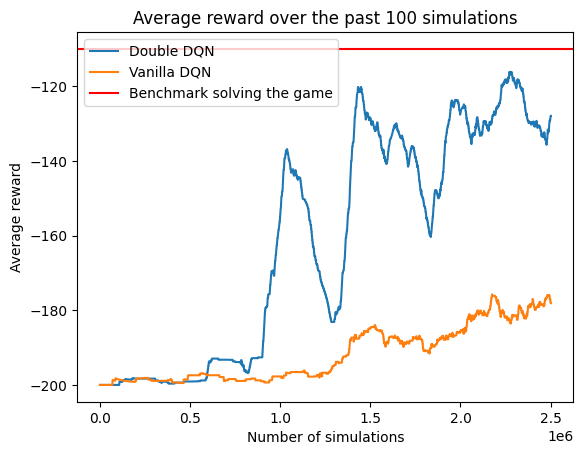

In [16]:
plt.plot(1000*(np.arange(len(average_rewards_ddqn))+1),average_rewards_ddqn)
plt.plot(1000*(np.arange(len(average_rewards_vanilla_dqn))+1),average_rewards_vanilla_dqn)
# specifying horizontal line type
plt.axhline(y = -110, color = 'r', linestyle = '-')
plt.title('Average reward over the past 100 simulations')
plt.xlabel('Number of simulations')
plt.legend(['Double DQN', 'Vanilla DQN', 'Benchmark solving the game'])
plt.ylabel('Average reward')

As we can see, the Double DQN performs significantly better than the vanilla DQN. The horizontal redline is the benchmark, as one considers the mountain car environment to be solved when the average reward over 100 subsequent trials is -110 ([check this link for further info](https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0)).

You can play around the hyperparameter and see how the results change if, for example, you lower the discount rate or learning rate! Also, you can see if changing the neural network architecture, i.e. making it deeper, will lead to an increase in performance.

## Reap the rewards of the hard work - see the DDQN play the game! 

Now that we worked through two different deep reinforcement learning architectures, we can see the DQN solve the game. The code below with let the DQNAgent play the mountain car game. 

In [17]:
dagent.play_game()

e:\Users\Linuxer\miniconda3\envs\rl_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Visualize the result in a 3D plot 

We can visualize the result in a 3D plot, plotting the x-position as well as the velocity with the corresponding value function. To recall, the value of a particular state is, in case of a greedy policy, the corresponding maximum state action pair! The following function will plot the value function.

The following code will plot the value function that results of the DDQN algorithm in 3D.

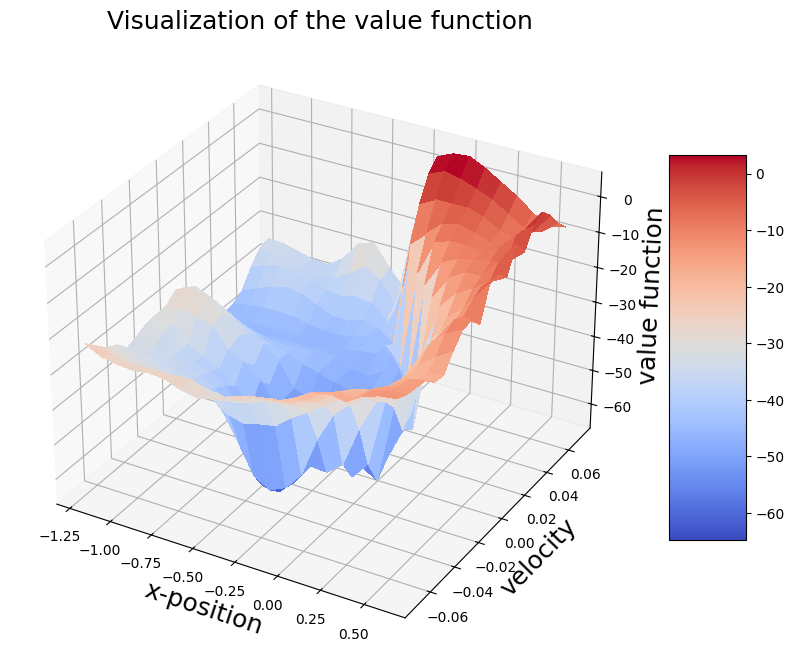

In [18]:
low = dagent.env.observation_space.low
high = dagent.env.observation_space.high

bin_size = 20
bin_x = np.linspace(low[0], high[0], bin_size)
bin_velocity = np.linspace(low[1], high[1], bin_size)

X, Y = np.meshgrid(bin_x, bin_velocity)
Z = np.zeros((len(X), len(Y)))

for i in range(len(X)):
    for j in range(len(Y)):
        Z[i][j] = dagent.return_q_value([X[0][i], Y[j][0]])
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.set_xlabel('x-position', fontsize = 18)
ax.set_ylabel('velocity', fontsize = 18)
ax.set_zlabel('value function', fontsize = 18)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Visualization of the value function', fontsize = 18)
plt.show()

**Your turn!**

You can play around with the deep reinforcement learning architecture and see what impact for example the discount rate has. Also, you can modify the architecture of the neural network (by making it more deep and/or change the activation function). Just have fun!

## Extensions/Interesting notes: 

Following the sucess of the paper by Minh et al. (2013), research in deep reinforcement learning has progressed and a couple of extensions to the basic framework as well as tricks have been proposed, such as dueling deep Q learning (also called D3QN) and priotized experience replay. But before I give you some pointers on this, we will discuss the deadly triad in a bit more detail.


## 1) The deadly triad

Some of you might have heard of the term 'deadly triad' which refers to the instability a reinforcement learning algorithm faces, when an algorithm makes use of:

- function approximation
- bootstrapping
- off-policy evaluation

Our deep reinforcement learning algorithm makes use of all three concepts. Yet, it does **not** state that instability/divergence always occur when all three above-mentioned techniques are used. The deadly triad only states that it **can** occur. An interesting paper that addresses this issue empirically is the following paper by van Hasselt et al. (2018) [Deep Reinforcement Learning and the Deadly Triad](https://arxiv.org/pdf/1812.02648.pdf)

For doing this, they realize that if one bounds the rewards in the interval between $[-1,1]$, then one can show that the corresponding Q values are bounded given by the following equation:

$  \sum_{t'=t}^{T} \gamma^{t'-t} |r_{t'}| \le \sum_{t'=t}^{\infty} \gamma^{t'-t} |r_{t'}| \le \sum_{t'=t}^{\infty} \gamma^{t'-t} = \frac{1}{1-\gamma}  $

According to this, any Q-value is theoretically bounded by the above equation. In our case, by $100$ (given a discount rate of $0.99$). Hence, if the Q-value exceeds this bound, we say that soft divergence occurs.

In their work, they find via running several experiments interesting insights:

- If one does not correct for overestimating bias (by for example not using a target network), divergence can occur more frequently.

- Increasing the multistep return decreases the chance of divergence.

- The effect of the neural network size is not straightforward, as the best performing architectures in their experiment are large, but also tend to show some instabilities.

Hence, they suggest that one can prevent instabilities by reducing the overestimation bias and by bootstraping on a separate network (also using multi-step returns). 


## 2) The importance of the random seed - instability of the DeepRL 

As stressed [in this good post](https://spinningup.openai.com/en/latest/spinningup/spinningup.html#closing-thoughts), the performance of DeepRL algorithms is very sensitive to stochasticity and the particular choice of the hyperparameters chosen. For this reason, one should run any DeepRL algorithm on a number of different random seeds and carefully tune the hyperparameters. This aspect is also discussed in this [paper](https://arxiv.org/pdf/1708.04133.pdf).

In the following, we will show how setting different seeds affects the performance of the double deep Q network. The following code is inspired by the code [here](https://gymnasium.farama.org/tutorials/reinforce_invpend_gym_v26/)

In [19]:
rewards_for_different_seeds = []
for seed in range(5): # Here we go for 5 seeds only, as otherwise the code runs for too long!
    # Reset the pytorch and numpy seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Initialize the agent:
    dagent = DDQNAgent(env_name, device, epsilon_decay, epsilon_start, 
                       epsilon_end, discount_rate, lr, buffer_size, seed)
    
    rewards_for_different_seeds.append(training_loop(env_name, dagent, max_episodes, target_ = True)) 


Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!
----------------------------------------
Step 9999
Epsilon 0.05009500000000011
Avg Rew -200.0

----------------------------------------
Step 19999
Epsilon 0.05
Avg Rew -199.61

----------------------------------------
Step 29999
Epsilon 0.05
Avg Rew -199.29

----------------------------------------
Step 39999
Epsilon 0.05
Avg Rew -199.68

----------------------------------------
Step 49999
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 59999
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 69999
Epsilon 0.05
Avg Rew -200.0

----------------------------------------
Step 79999
Epsilon 0.05
Avg Rew -199.78

----------------------------------------
Step 89999
Epsilon 0.05
Avg Rew -199.78

----------------------------------------
Step 99999
Epsilon 0.05
Avg Rew -196.26

----------------------------------------


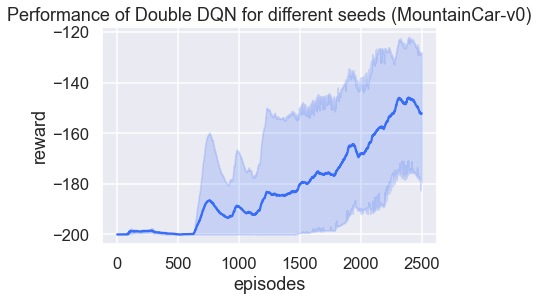

In [ ]:
#Create a dataframe to plot using seaborn library
rewards = pd.DataFrame(rewards_for_different_seeds).melt()
rewards.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=rewards).set(
    title="Performance of Double DQN for different seeds (MountainCar-v0)"
)
plt.show()

**Comment**:
As expected, the performance of the DDQN algrorithm is heavily affected by the different seeds! This illustrates the importance of running the experiment with different seeds!

## 3) Dynamic discount rate 

One of the hyperparameter that one needs to choose carefully is the discount rate $\gamma$. In their work, [Francois-Lavet et al. (2016)](https://arxiv.org/pdf/1512.02011.pdf) show that one can increase the performance and significantly decrease the number of learning steps required, by not only having a dynamic $\epsilon$ rate, but also by having a discount rate that increases over time. In particular, they suggest to:

$\gamma_{k+1} = 1 - 0.98(1- \gamma_{k}) $

The start value of gamma is set to $0.9$ and it increases up to a final value of $0.99$. You could try to implement this and check its effect on the result!


## 4) Priotized experience replay 

As we saw above, an important part of deep reinforcement learning is the experience replay buffer. This concept lets the agent remember and reuse old experiences from the past. Yet, those samples were sampled uniformly. Yet, one could imagine that some experiences are more fruitful for the agent to be replayed than others. Intuitively, one would like to replay experiences for which the agent can learn the most. To do this, one needs to change the sample procedure in a way that experiences for which the agent can learn more have a higher sampling probability. This is the key idea of the priotized experience replay buffer, as introduced by [Schaul et al. (2015)](https://arxiv.org/pdf/1511.05952.pdf). 
In their work, they propose to measure the expected learning significance by the magnitude of the temporal difference  (TD) error.

In particular, they propose the following. The priority of transition $p_{i}$ is based on the absolute magnitude of the TD error $\delta_{i}$ plus a small, positive constant $\epsilon$ which ensures that all samples have a non-zero probability to be resampled:

$p_{i} = |\delta_{i}| + \epsilon$

Then, the probability of sampling transition $i$ is defined as:

$P(i) = \frac {p_{i}^{\alpha}}{\sum_{k} p_{k}^{\alpha}}$ where $\alpha$ determines how much priotization is used (with $\alpha = 1$ representing the standard uniform case).

Given that we change the sampling procedure from a uniform one, to a different one in which transitions with a higher TD error have a higher chance of getting resampled, we need to correct for the bias that occurs as stochastic updates rely on the assumption that updates correspond to the same distribution as the expectation. This can be done via importance sampling, i.e. :

$w_{i} = (\frac {1}{N} \frac{1}{P(i)})^{\beta}$

where $N$ refers to the size of the replay buffer and $\beta$ to a hyperparameter (with 1 compensating fully for non-uniform probabilities). For stability reasons, they suggest to normalize the weights by dividing all weights by the corresponding largest weight in the buffer.

Having this, the only change on needs to do to for the training algorithm is to multiply the gradient in the update equation with $w_{i}$.

## 5) Dueling Deep Reinforcement learning - D3QN

Another extension to the standard DDQN framework is the idea of dueling deep reinforcement learning. This was introduced by [Wang et al. (2016).](https://arxiv.org/pdf/1511.06581.pdf).

The key idea is to note that the Q function can be decomposed into the value function $V(s)$ which denotes how valuable it is for an agent to be in a particular state $s$ and an advantage function $A(s,a)$ which determines how valuable it is to take a particular action $a$ in a state $s$:

$Q(s,a) = V(s) + A(s,a)$

Yet, given a particular Q function, one can decompose it into the components of $V(s)$ and $A(s,a)$ in many ways which  raises identifiability issues. To circumvent this issue, the authors suggest to force the highest Q value to be equal to the value function, i.e.

$Q(s,a) = V(s) + ( A(s,a) - max_{a' \in |A|}A(s,a'))$

Alternatively, one can do it also using the average over all actions:


$Q(s,a) = V(s) + A(s,a) - \frac{1}{||a||}\sum_{a'}A(s,a')$

To implement this in PyTorch, one only needs to seperate the layers into two different streams, where one layer calculates the value function and the other one the advantage function. Lastly, one needs to then aggregate them again (and subtract the average!).